In [13]:
import pandas as pd

def verify_data(file_path):
    # Read the file
    df = pd.read_csv(file_path)
    
    # Basic counts
    print("Basic Data Analysis:")
    print(f"Total rows in dataset: {len(df)}")
    
    # Check Equation ID 4582
    eq_data = df[df['Equation ID'] == 4582]
    print(f"\nEquation ID 4582 Analysis:")
    print(f"Total rows with Equation ID 4582: {len(eq_data)}")
    
    # Check unique combinations
    print("\nUnique value counts:")
    print(f"Unique thicknesses: {eq_data['thickness'].nunique()}")
    print(f"Unique time delays: {eq_data['time_delay'].nunique()}")
    print(f"Unique model ratios: {eq_data['model_ratio'].nunique()}")
    
    # Show sample of data
    print("\nSample of rows with Equation ID 4582:")
    print(eq_data[['Equation ID', 'thickness', 'time_delay', 'model_ratio']].head(10))
    
    # Check for any filtering issues
    print("\nChecking for potential filtering issues:")
    print("Equation ID values:", df['Equation ID'].value_counts()[4582])
    
    # Check data types
    print("\nData types:")
    print(df.dtypes)

if __name__ == "__main__":
    file_path = '/Users/shiveshjha/Downloads/TDTR_WITH_ML-MAIN/equation_generation/test_results_by_modelratio (11).csv'
    verify_data(file_path)

Basic Data Analysis:
Total rows in dataset: 238360

Equation ID 4582 Analysis:
Total rows with Equation ID 4582: 295

Unique value counts:
Unique thicknesses: 5
Unique time delays: 59
Unique model ratios: 59

Sample of rows with Equation ID 4582:
       Equation ID  thickness  time_delay  model_ratio
82870         4582       80.0   3387.8525     1.226423
82871         4582      160.0   3387.8525     1.226423
82872         4582      240.0   3387.8525     1.226423
82873         4582      320.0   3387.8525     1.226423
82874         4582      400.0   3387.8525     1.226423
86110         4582       80.0   3188.2068     1.244610
86111         4582      160.0   3188.2068     1.244610
86112         4582      240.0   3188.2068     1.244610
86113         4582      320.0   3188.2068     1.244610
86114         4582      400.0   3188.2068     1.244610

Checking for potential filtering issues:
Equation ID values: 295

Data types:
Row_ID                int64
Equations            object
Equation ID  

In [14]:

import matlab.engine
import pandas as pd
import numpy as np
import os
from datetime import datetime
import sys

def analyze_data(df, equation_id):
    """
    Analyze data structure for a specific equation ID
    """
    eq_data = df[df['Equation ID'] == equation_id].copy()
    print(f"\nAnalysis for Equation ID {equation_id}:")
    print(f"Total rows: {len(eq_data)}")
    
    # Check unique combinations
    unique_combinations = eq_data.groupby(['thickness', 'time_delay', 'model_ratio']).size().reset_index()
    print(f"\nUnique combinations of thickness, time_delay, model_ratio: {len(unique_combinations)}")
    
    # Display value counts for each parameter
    print("\nUnique values for each parameter:")
    print(f"Thickness values: {eq_data['thickness'].nunique()}")
    print(f"Time delay values: {eq_data['time_delay'].nunique()}")
    print(f"Model ratio values: {eq_data['model_ratio'].nunique()}")
    
    return eq_data

def batch_process_predictions(df_chunk, eng, temp_output_dir, batch_size=100):
    """
    Process predictions in batches
    """
    predictions = []
    
    # Create all lambda arrays first
    lambda_arrays = []
    file_names = []
    
    for _, row in df_chunk.iterrows():
        k_array = [
            140,    # Al layer
            0.06,   # Layer 2
            row['y_pred'],  # Layer 3-7 (using predicted value)
            row['y_pred'],
            row['y_pred'],
            row['y_pred'],
            row['y_pred'],
            0.1,    # Interface layer
            10      # Bottom layer
        ]
        lambda_arrays.append(k_array)
        file_names.append(f"Equation_{int(row['Equation ID'])}_{row['thickness']}")

    # Process in batches
    for i in range(0, len(lambda_arrays), batch_size):
        batch_end = min(i + batch_size, len(lambda_arrays))
        current_batch = lambda_arrays[i:batch_end]
        current_files = file_names[i:batch_end]
        
        # Redirect MATLAB output
        stdout_backup = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
        try:
            # Process each in batch
            for arr, fname in zip(current_batch, current_files):
                eng.TDTR_MAIN_V4(matlab.double(arr), fname, nargout=0)
                
                # Process output file
                output_file = os.path.join(temp_output_dir, f"{fname}.txt")
                if os.path.exists(output_file):
                    try:
                        data = pd.read_csv(output_file, sep='\s+', header=None)
                        time_delays = data.iloc[:, 0].values
                        model_ratios = data.iloc[:, -1].values
                        idx = np.abs(time_delays - df_chunk.iloc[len(predictions)]['time_delay']).argmin()
                        predictions.append(float(model_ratios[idx]))
                    except:
                        predictions.append(None)
                    finally:
                        try:
                            os.remove(output_file)
                        except:
                            pass
                else:
                    predictions.append(None)
        finally:
            sys.stdout = stdout_backup
            
    return predictions

def process_results_file(input_file, base_dir, chunk_size=1000):
    """
    Process the results file in larger chunks
    """
    print("Reading input file...")
    df = pd.read_csv(input_file)
    target_equations = [4582]
    
    # First analyze the data
    print(f"\nBefore filtering:")
    print(f"Total rows in dataset: {len(df)}")
    print(f"Rows with equation ID 4582: {len(df[df['Equation ID'] == 4582])}")
    
    # Analyze the data structure
    eq_data = analyze_data(df, 4582)
    
    # Create copy of original data for target equations
    df_filtered = df[df['Equation ID'].isin(target_equations)].copy().reset_index(drop=True)
    
    if len(df_filtered) == 0:
        print("No target equations found!")
        return
    
    print(f"\nProcessing {len(df_filtered)} rows for target equations...")
    
    print("Starting MATLAB engine...")
    eng = matlab.engine.start_matlab()
    
    try:
        predicted_ratios = []
        total_chunks = (len(df_filtered) + chunk_size - 1) // chunk_size
        
        for chunk_idx in range(total_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min(start_idx + chunk_size, len(df_filtered))
            
            print(f"\nProcessing chunk {chunk_idx + 1}/{total_chunks}")
            chunk = df_filtered.iloc[start_idx:end_idx]
            
            # Process this chunk
            chunk_predictions = batch_process_predictions(chunk, eng, base_dir)
            predicted_ratios.extend(chunk_predictions)
            
            # Show progress
            progress = (len(predicted_ratios) / len(df_filtered)) * 100
            print(f"Overall progress: {progress:.1f}%")
            
            # Diagnostic information
            print(f"Chunk size: {len(chunk)}")
            print(f"Predictions in this chunk: {len(chunk_predictions)}")
            
        # Add predictions to dataframe
        df_filtered['model_ratio_pred'] = predicted_ratios
        
        # Save results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_filename = f"results_with_predictions_{timestamp}.csv"
        output_path = os.path.join(base_dir, output_filename)
        
        # Save all original columns plus the new predictions
        df_filtered.to_csv(output_path, index=False)
        
        print(f"\nProcessing complete:")
        print(f"Total rows processed: {len(df_filtered)}")
        print(f"Successful predictions: {sum(x is not None for x in predicted_ratios)}")
        print(f"Output saved to: {output_filename}")
        
    finally:
        print("Closing MATLAB engine...")
        eng.quit()
    
    return df_filtered

def main():
    base_dir = '/Users/shiveshjha/Downloads/TDTR_WITH_ML-MAIN/equation_generation/'
    input_file = 'test_results_by_modelratio (11).csv'
    
    try:
        df_result = process_results_file(input_file, base_dir)
        print("\nFinal Statistics:")
        print(f"Total rows in result: {len(df_result)}")
        print(f"Unique combinations processed: {df_result.groupby(['thickness', 'time_delay', 'model_ratio']).size().shape[0]}")
    except Exception as e:
        print(f"Error: {str(e)}")
        raise

if __name__ == "__main__":
    main()


<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g3/q9lsfqzx0j966dx358nvy3v00000gn/T/ipykernel_44671/3888798574.py:72: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(output_file, sep='\s+', header=None)


Reading input file...

Before filtering:
Total rows in dataset: 238360
Rows with equation ID 4582: 295

Analysis for Equation ID 4582:
Total rows: 295

Unique combinations of thickness, time_delay, model_ratio: 295

Unique values for each parameter:
Thickness values: 5
Time delay values: 59
Model ratio values: 59

Processing 295 rows for target equations...
Starting MATLAB engine...

Processing chunk 1/1
Fitting Solution:
Output file saved as: Equation_4582_80.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_160.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_240.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_320.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_400.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_80.0.txt
Program Completed
Fitting Solution:
Output file saved as: Equation_4582_160.0.txt
Program Completed
Fitting Solution:
Ou

Reading results file...
Found 1 unique equations
Creating plots for Equation ID 4582


/var/folders/g3/q9lsfqzx0j966dx358nvy3v00000gn/T/ipykernel_44671/2850878638.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


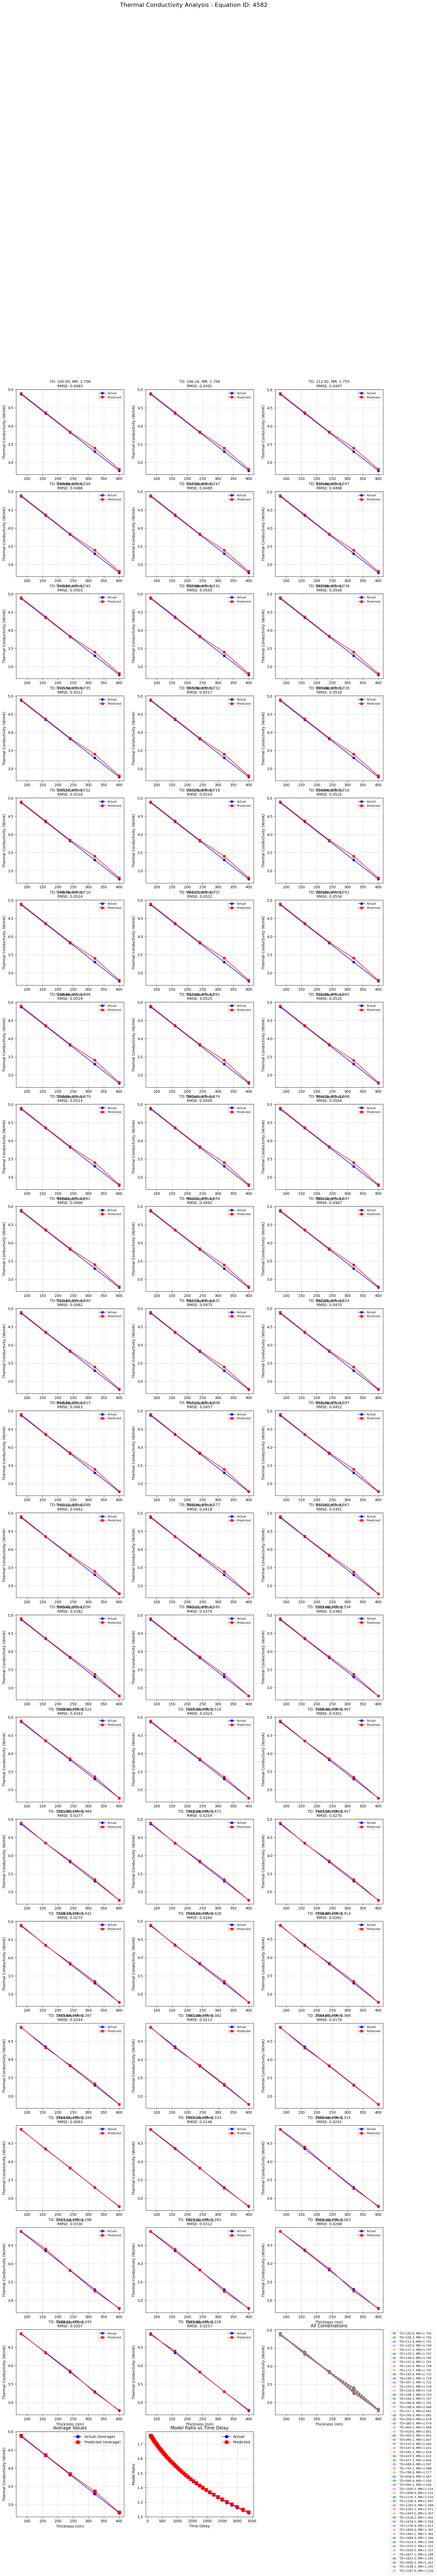

In [16]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def set_axis_limits(ax, x_data, y_data, padding=0.1):
    x_min, x_max = np.min(x_data), np.max(x_data)
    y_min, y_max = np.min(y_data), np.max(y_data)
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - padding * x_range, x_max + padding * x_range)
    ax.set_ylim(y_min - padding * y_range, y_max + padding * y_range)

def create_plots_for_equation(df, equation_id):
    eq_data = df[df['Equation ID'] == equation_id].copy()
    
    if len(eq_data) == 0:
        print(f"No data found for Equation ID {equation_id}")
        return
    
    # Get number of unique combinations
    combinations = eq_data.groupby(['time_delay', 'model_ratio']).size().reset_index()
    n_combinations = len(combinations)
    
    # Create figure with n_combinations + 3 subplots (combinations + 3 average plots)
    n_cols = min(3, n_combinations + 3)
    n_rows = ((n_combinations + 3) + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(6*n_cols, 5*n_rows))
    plt.suptitle(f'Thermal Conductivity Analysis - Equation ID: {equation_id}', fontsize=16, y=1.02)
    
    # First, create individual combination plots
    for idx, (_, combo) in enumerate(combinations.iterrows(), 1):
        time_delay = combo['time_delay']
        model_ratio = combo['model_ratio']
        
        mask = (eq_data['time_delay'] == time_delay) & (eq_data['model_ratio'] == model_ratio)
        plot_data = eq_data[mask].sort_values('thickness')
        
        ax = fig.add_subplot(n_rows, n_cols, idx)
        ax.plot(plot_data['thickness'], plot_data['y_actual'], 'o-', 
               label='Actual', color='blue', markersize=6)
        ax.plot(plot_data['thickness'], plot_data['y_pred'], 's-', 
               label='Predicted', color='red', markersize=6)
        
        rmse = np.sqrt(np.mean((plot_data['y_actual'] - plot_data['y_pred'])**2))
        
        ax.set_xlabel('Thickness (nm)', fontsize=10)
        ax.set_ylabel('Thermal Conductivity (W/mK)', fontsize=10)
        ax.set_title(f'TD: {time_delay:.2f}, MR: {model_ratio:.3f}\nRMSE: {rmse:.4f}',
                    fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=8)
        
        set_axis_limits(ax, plot_data['thickness'], 
                       pd.concat([plot_data['y_actual'], plot_data['y_pred']]), 
                       padding=0.05)
    
    # Create the three average plots
    # Plot 1: All combinations
    ax1 = fig.add_subplot(n_rows, n_cols, n_combinations + 1)
    unique_combinations = eq_data.groupby(['time_delay', 'model_ratio'])
    for (time_delay, model_ratio), group in unique_combinations:
        label = f'TD={time_delay:.1f}, MR={model_ratio:.3f}'
        ax1.plot(group['thickness'], group['y_actual'], 'o-', 
                label=label, alpha=0.5, markersize=6)
        ax1.plot(group['thickness'], group['y_pred'], 's--', 
                alpha=0.5, markersize=6)
    
    ax1.set_xlabel('Thickness (nm)', fontsize=10)
    ax1.set_ylabel('Thermal Conductivity (W/mK)', fontsize=10)
    ax1.set_title('All Combinations', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Average Thermal Conductivity
    ax2 = fig.add_subplot(n_rows, n_cols, n_combinations + 2)
    thickness_avg = eq_data.groupby('thickness').agg({
        'y_actual': 'mean',
        'y_pred': 'mean'
    }).reset_index()
    
    ax2.plot(thickness_avg['thickness'], thickness_avg['y_actual'], 'o-', 
             label='Actual (Average)', color='blue', markersize=8)
    ax2.plot(thickness_avg['thickness'], thickness_avg['y_pred'], 's-', 
             label='Predicted (Average)', color='red', markersize=8)
    
    ax2.set_xlabel('Thickness (nm)', fontsize=10)
    ax2.set_ylabel('Thermal Conductivity (W/mK)', fontsize=10)
    ax2.set_title('Average Values', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Plot 3: Model Ratio vs Time Delay
    ax3 = fig.add_subplot(n_rows, n_cols, n_combinations + 3)
    time_delay_avg = eq_data.groupby('time_delay').agg({
        'model_ratio': 'mean',
        'model_ratio_pred': 'mean'
    }).reset_index()
    
    ax3.plot(time_delay_avg['time_delay'], time_delay_avg['model_ratio'], 'o-', 
             label='Actual', color='blue', markersize=8)
    ax3.plot(time_delay_avg['time_delay'], time_delay_avg['model_ratio_pred'], 's-', 
             label='Predicted', color='red', markersize=8)
    
    ax3.set_xlabel('Time Delay', fontsize=10)
    ax3.set_ylabel('Model Ratio', fontsize=10)
    ax3.set_title('Model Ratio vs Time Delay', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend()
    
    plt.tight_layout()
    return fig

def main():
    base_dir = '/Users/shiveshjha/Downloads/TDTR_WITH_ML-MAIN/equation_generation/'
    input_file = 'results_with_predictions.csv'
    
    print("Reading results file...")
    df = pd.read_csv(os.path.join(base_dir, input_file))
    
    equation_ids = sorted(df['Equation ID'].unique())
    print(f"Found {len(equation_ids)} unique equations")
    
    for eq_id in equation_ids:
        print(f"Creating plots for Equation ID {eq_id}")
        fig = create_plots_for_equation(df, eq_id)
        if fig:
            plt.show()
            plt.close(fig)

if __name__ == "__main__":
    main()
